In [1]:
%run style_and_packages.ipynb

# Beispiel: Rayleigh-Quotient und Fundamentsteifigkeit beim Ersatzkraftverfahren
## Aufgabenstellung

In @fig-ekv_rayleigh_system ist ein Gebäudegrundriss dargestellt. Dieser wird durch drei Stahlbeton-Wandscheiben ausgesteift. Die Anordnung ist symmetrisch, das Steifigkeitszentrum stimmt mit dem Massenzentrum der Decke überein.

![Grundriss des Gebäudes](bilder/aufgabe_ekv_rayleigh_GR.svg){#fig-ekv_rayleigh_system}

Das Untergeschoss gilt als *steifer Kasten*, folglich ist der Einspannungshorizont der Wandscheiben Oberkante UG. Es findet eine gewisse Einspannung der Wandscheiben in die Bodenplatte statt, je nach Ausbildung der Fundation. Diese kann man z.B. mit einer elastischen Einspannung (Drehfeder) modellieren. Die elastische Einspannung liegt im Bereich von 20% einer Volleinspannung. Im Beispiel wird diese als gelenkige Lagerung angenommen.

![Ansicht der Wand 3 des Gebäudes](bilder/aufgabe_ekv_gebaude_ansicht.svg){#fig-ekv_rayleigh_systemansicht}

Die Modellierung in @fig-ekv_rayleigh_systemmodell trifft folgende Annahmen:

- Die Decken sind gelenkig an die Tragwände angeschlossn
- Die Deckenscheiben wirken in ihrer Ebene als starre Scheiben
- Die Wandscheiben bzw. Tragwände sind in den Kellerkasten eingespannt, so dass die Modellierung als Kragarm gerechtfertigt ist
- Die Massen der Decken werden im Aufriss als Punktmassen am Kragarm abgebildet (Dabei werden die Massen der Wände pro Geschoss je zur Hälfte der Geschossmassen zugeordnet)
- Die Stützen tragen lediglich zum vertikalen Lastabtrag bei. Deren Steifigkeit kann vernachlässigt werden


![Modellierung als Mehrmassenschwinger](bilder/aufgabe_ekv_3ms.svg){#fig-ekv_rayleigh_systemmodell}

Gesucht:

- Erste Eigenperiode in globaler Y-Richtung
- Ersatzkräfte durch das Ersatzkraftverfahren

Gegeben:

- Baugrundklasse $B$
- Erdbebenzone $Z2$
- Decken und Wände sind alle $d$ stark
- Sämtliche Decken gelten als Wohnflächen (Lastermittlung - vereinfacht auch die Dachfläche)
- Reduktion der Biegesteifigkeit $\gamma_{EI}$ zur Berücksichtigung der Rissbildung


In [2]:
rho_c, gamma_f, q,q_auflast_k, q_nutzlast_k = sp.symbols('rho_c, gamma_f, q, q_auflast_k, q_nutzlast_k')
H_1, H_2, H_3 = sp.symbols("H_1, H_2, H_3")
m_1, m_2, m_3 = sp.symbols('m_1, m_2, m_3')

gamma_EI = sp.symbols('gamma_EI')

F_1, F_2, F_3 = sp.symbols('F_1, F_2, F_3')

E, d, L_y, L_x, L_w1, L_w2, L_w3 = sp.symbols('E, d, L_y, L_x, L_w1, L_w2, L_w3')


C_1 = sp.symbols('C_1')


H = sp.symbols('H', positive=True)

u_0 = sp.symbols('u_0')


G_c, nu_c = sp.symbols('G_c, nu_c')

G_eff_sand, nu_sand = sp.symbols('G_eff_sand nu_sand')

In [3]:
#| label: tbl-parameter_ekv1
#| tbl-cap: Verwendete Parameter der Aufgabe

params = {
    'E':30000 *unit.N/unit.mm**2,
    'd':0.3*unit.m,
    'L_y':5*unit.m, 
    'L_x':4*unit.m,
    'L_w1':4*unit.m,
    'L_w2':4*unit.m,
    'L_w3':5*unit.m,
    'q': 2.0,
    'gamma_f': 1.0,
    'q_nutzlast_k': 3*10**3*unit.N/unit.m**2,
    'q_auflast_k': 1*10**3*unit.N/unit.m**2,
    'H_1':4*unit.m,
    'H_2':4*unit.m,
    'H_3':4*unit.m,
    'rho_c':25000*unit.N / unit.m**3,
    'g':10 *unit.m/unit.second**2,
    'gamma_EI':0.50,
    'G_eff_sand':120*10**6*unit.N/unit.m**2,
    'nu_sand':0.3,

}
params_plot = convert.param_value(params)
render.dict_to_table(params)

|   |   |
|---|---|
| $E = \frac{30000 \text{N}}{\text{mm}^{2}}$ | $G_{eff sand} = \frac{120000000 \text{N}}{\text{m}^{2}}$ |
| $H_{1} = 4 \text{m}$ | $H_{2} = 4 \text{m}$ |
| $H_{3} = 4 \text{m}$ | $L_{w1} = 4 \text{m}$ |
| $L_{w2} = 4 \text{m}$ | $L_{w3} = 5 \text{m}$ |
| $L_{x} = 4 \text{m}$ | $L_{y} = 5 \text{m}$ |
| $d = 0.3 \text{m}$ | $g = \frac{10 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{EI} = 0.5$ | $\gamma_{f} = 1.0$ |
| $\nu_{sand} = 0.3$ | $q = 2.0$ |
| $q_{auflast k} = \frac{1000 \text{N}}{\text{m}^{2}}$ | $q_{nutzlast k} = \frac{3000 \text{N}}{\text{m}^{2}}$ |
| $\rho_{c} = \frac{25000 \text{N}}{\text{m}^{3}}$ | |


{{< pagebreak >}}

## Musterlösung

### Lastermittlung

Gemäss @SIA261_2020 Ziff. 16.5.2.3 sind ständige und quasiständige Lasten anzusetzen.
Bei der Lastermittlung werden die Gewichtskräfte aus Eigenmassen und Auflasten ermittelt. Dazu werden pro Stockwerk die Gewichtskräfte der Wände definiert. Eine Punktmasse erhält jeweils die Hälfte der darunter- und darüber liegenden Wände. Für die Decke über 2.OG bleibt folglich nur eine Hälfte der Wände.

In [4]:



A_decke = 5*L_x* 3 * L_y
G_decke = A_decke * rho_c* d
G_waende_stock = (L_w1 +L_w2+L_w3)*H_1 * rho_c * d
Q_auflast_k = q_auflast_k * A_decke
Q_nutzlast_k = q_nutzlast_k * A_decke
psi_2 = 0.3

params['m_3'] = ((G_decke + Q_auflast_k+ G_waende_stock/2+psi_2 * Q_nutzlast_k)/g).subs(params)
params['m_2'] = ((G_decke + Q_auflast_k+ G_waende_stock+psi_2 * Q_nutzlast_k)/g).subs(params)
params['m_1'] = ((G_decke + Q_auflast_k+ G_waende_stock+psi_2 * Q_nutzlast_k)/g).subs(params)

render.eq_display('A_Decke', A_decke.subs(params).evalf(3),
                  'G_Decke_k', G_decke.subs(params).evalf(3),
                  'G_Waende_k', G_waende_stock.subs(params).evalf(3),
                  'Q_auflast_k', Q_auflast_k.subs(params).evalf(3),
                  'Q_nutzlast_k', Q_nutzlast_k.subs(params).evalf(3),
                  'psi_2', psi_2,
                  )



                     2
A_Decke = 300.0⋅meter 

G_Decke_k = 2.25e+6⋅newton

G_Waende_k = 3.9e+5⋅newton

Q_auflast_k = 3.0e+5⋅newton

Q_nutzlast_k = 9.0e+5⋅newton

ψ₂ = 0.3

Daraus lassen sich die Punktmassen bestimmen:

In [5]:
render.eq_display('m_1', "(G_decke + Q_auflast_k+ G_Waende_k+psi_2 * Q_nutzlast_k)/g",
                 'm_1', m_1.subs(params).evalf(3),
                 'm_2', "(G_decke + Q_auflast_k+ G_Waende_k+psi_2 * Q_nutzlast_k)/g",
                 'm_2', m_2.subs(params).evalf(3),
                 'm_3', "(G_decke + Q_auflast_k+ G_Waende_k/2+psi_2 * Q_nutzlast_k)/g",
                 'm_3', m_3.subs(params).evalf(3))

     G_Waende_k + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
m₁ = ────────────────────────────────────────────────────
                              g                          

                          2
     3.21e+5⋅newton⋅second 
m₁ = ──────────────────────
             meter         

     G_Waende_k + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
m₂ = ────────────────────────────────────────────────────
                              g                          

                          2
     3.21e+5⋅newton⋅second 
m₂ = ──────────────────────
             meter         

     G_Waende_k                                          
     ────────── + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
         2                                               
m₃ = ────────────────────────────────────────────────────
                              g                          

                          2
     3.02e+5⋅newton⋅second 
m₃ = ──────────────────────
             meter         

### Biegesteifigkeit

Die Biegesteifigkeit wird in Y-Richtung bestimmt. Es wird lediglich Wand 3 berücksichtigt. Die Reduktion zur Berücksichtigung der Rissbildung ist ebenfalls miteinbezogen.

In [6]:
I_y = L_w3 ** 3 * d / 12

EI_y_ersatz = I_y * E * gamma_EI

render.eq_display(
    'I_y' , 'L_w3 ** 3 * d / 12',
    'I_y' , I_y.subs(params).evalf(3),
    'EI_y_ersatz', I_y * E * gamma_EI,
    'EI_y_ersatz', EI_y_ersatz.subs(params).evalf(3).simplify())

          3  
      L_w3 ⋅d
I_y = ───────
         12  

                4
I_y = 3.13⋅meter 

                    3       
              E⋅L_w3 ⋅d⋅γ_EI
EI_y_ersatz = ──────────────
                    12      

                            2       
EI_y_ersatz = 4.69e+10⋅meter ⋅newton

### Formfunktion aus der Biegelinie

Als geeignete statische Belastung für die Abbildung der Eigenform eignet sich eine lineare dreicksförmige Verteilung von Einzellasten. Diese bewirken am Stab eine Verschiebung $u_i$ auf Höhe der Geschossdecken.

#### Rayleigh-Quotient

Gemäss dem Arbeitssatz gilt: Die von den äusseren Kräften $F_i$ auf ihren Verschiebungswegen $u_i$ geleistete Arbeit entspricht der inneren Arbeit, welche von den Schnittgrössen auf den Dehnungen im Querschnitt geleistet wird.

$$
W_a = W_i
$${#eq-ekv_rayleigh_arbeit}

Dies führt zur @eq-ekv_rayleigh_rayleigh:

$$
\frac{1}{2} \sum_{i=1}^n F_i\cdot u_i=\int_0^L \frac{1}{2} EI \cdot u''(x)^2 \cdot d_x
$${#eq-ekv_rayleigh_rayleigh}

Unter Berücksichtigung, dass die Stäbe als masselos zu betrachten sind (da die Massen der Wände zu den Punktmassen dazugezählt sind), lässt sich die Eigenkreisfrequenz gemäss @eq-ekv_rayleigh_eigenkreis beschreiben.

$$
\omega_1^2 = \frac{\frac{1}{2}\sum_{i=1}^n F_i \cdot u_i}{\frac{1}{2}\sum_{i=1}^n m_i \cdot u_i^2} = \frac{\text{max. potentielle Energie}}{\text{max. kinetische Energie}}
$${#eq-ekv_rayleigh_eigenkreis}

Zur Ermittlung der Biegelinie, bzw. der Verformungen $u_i$ wird das gleiche Vorgehen wie bei der Ermittlung der Nachgiebigkeitsmatrix angewendet.

![System mit Einwirkungen zur Bestimmung der Formfunktion anhand der Biegelinie](bilder/aufgabe_ekv_rayleigh_biege.svg){#fig-ekv_rayleigh_biegelinie}

Daraus lassen sich die Kräftezustände beschreiben:

![Schnittgrössen im realen und fiktiven Kräftezustand](bilder/aufgabe_ekv_rayleigh_biege_schnittgroessen.svg){#fig-ekv_rayleigh_realfikt}


Durch die Anwendung der Arbeitsgleichung lassen sich die jeweiligen Deformationen bestimmen. Die Indizes $ij$ in $\delta_{ij}$ bedeuten $i$ Position der realen Einwirkung und $j$ Position der fiktiven Einwirkung. Dies resultiert zur Nachgiebigkeitsmatrix. Invertiert folgt daraus die Steifigkeitsmatrix. Mit den Einwirkungen multipliziert folgt die Deformation an jedem Punkt.

Zur Bestimmung der Nachgiebigkeitsmatrix werden die Kräfte $F_i = 1$ gesetzt. Durch Multiplikation mit dem effektiven Kraftvektor resultieren die entsprechenden Verformungen.

In [7]:
F_1_n, F_2_n, F_3_n = 1 ,1 ,1

In [8]:
def delta_ij(M, m_l, m_r, L):
    return (sp.Rational(1,6) / EI_y_ersatz) * M*(m_l+2*m_r)*L

In [9]:
delta_11 = delta_ij(F_1_n * H_1, 0, H_1, H_1)
delta_22 = delta_ij(F_2_n * (H_1+H_2), 0, (H_1+H_2), (H_1+H_2))
delta_33 = delta_ij(F_3_n * (H_1+H_2+H_3), 0, (H_1+H_2+H_3), (H_1+H_2+H_3))

delta_12 = delta_ij(F_1_n*H_1, H_1, H_1+H_2, H_1)
delta_21 = delta_12

delta_13 = delta_ij(F_1_n*H_1,H_1+H_2, H_1+H_2+H_3, H_1)
delta_31 = delta_13

delta_23 = delta_ij(F_2_n*(H_1+H_2), H_3, H_1+H_2+H_3, H_1 + H_2)
delta_32 = delta_23

render.eq_render(locals(), raw_input=False)

              3     
          4⋅H₁      
δ₁₁ = ──────────────
            3       
      E⋅L_w3 ⋅d⋅γ_EI

                 2              
      2⋅(H₁ + H₂) ⋅(2⋅H₁ + 2⋅H₂)
δ₂₂ = ──────────────────────────
                  3             
            E⋅L_w3 ⋅d⋅γ_EI      

                      2                     
      2⋅(H₁ + H₂ + H₃) ⋅(2⋅H₁ + 2⋅H₂ + 2⋅H₃)
δ₃₃ = ──────────────────────────────────────
                        3                   
                  E⋅L_w3 ⋅d⋅γ_EI            

          2              
      2⋅H₁ ⋅(3⋅H₁ + 2⋅H₂)
δ₁₂ = ───────────────────
               3         
         E⋅L_w3 ⋅d⋅γ_EI  

          2              
      2⋅H₁ ⋅(3⋅H₁ + 2⋅H₂)
δ₂₁ = ───────────────────
               3         
         E⋅L_w3 ⋅d⋅γ_EI  

          2                     
      2⋅H₁ ⋅(3⋅H₁ + 3⋅H₂ + 2⋅H₃)
δ₁₃ = ──────────────────────────
                  3             
            E⋅L_w3 ⋅d⋅γ_EI      

          2                     
      2⋅H₁ ⋅(3⋅H₁ + 3⋅H₂ + 2⋅H₃)
δ₃₁ = ──────────────────────────
                  3             
            E⋅L_w3 ⋅d⋅γ_EI      

                 2                     
      2⋅(H₁ + H₂) ⋅(2⋅H₁ + 2⋅H₂ + 3⋅H₃)
δ₂₃ = ─────────────────────────────────
                      3                
                E⋅L_w3 ⋅d⋅γ_EI         

                 2                     
      2⋅(H₁ + H₂) ⋅(2⋅H₁ + 2⋅H₂ + 3⋅H₃)
δ₃₂ = ─────────────────────────────────
                      3                
                E⋅L_w3 ⋅d⋅γ_EI         

Eingesetzt in die Nachgiebigkeitsmatrix und mit dem Kraftvektor multipliziert:

In [10]:

params['F_1'] = 1000*unit.N
params['F_2'] = 2000*unit.N
params['F_3'] = 3000*unit.N

In [11]:
D_matrix = sp.Matrix([[delta_11, delta_12, delta_13],[delta_21, delta_22, delta_23],[delta_31, delta_32, delta_33]])


F_vektor = sp.Matrix([[F_1],[F_2],[F_3]])

u_vektor = D_matrix * F_vektor
render.eq_display(
    sp.MatrixSymbol('D', 3,3), 
sp.simplify(D_matrix),
    sp.MatrixSymbol('D', 3,3), 
unit.convert_to(sp.simplify(D_matrix.subs(params)).evalf(3), unit.mm),
    sp.MatrixSymbol('F', 3,1), F_vektor.subs(params),
    'u', 'D * F',
    sp.MatrixSymbol('u', 3,1), unit.convert_to(sp.simplify(u_vektor.subs(params)).evalf(3), unit.mm))

    ⎡             3                     2                            2        
    ⎢         4⋅H₁                    H₁ ⋅(6⋅H₁ + 4⋅H₂)            H₁ ⋅(6⋅H₁ +
    ⎢     ──────────────              ─────────────────            ───────────
    ⎢           3                             3                               
    ⎢     E⋅L_w3 ⋅d⋅γ_EI                E⋅L_w3 ⋅d⋅γ_EI                  E⋅L_w3
    ⎢                                                                         
    ⎢     2                                        3                     2    
    ⎢   H₁ ⋅(6⋅H₁ + 4⋅H₂)               4⋅(H₁ + H₂)             (H₁ + H₂) ⋅(4⋅
D = ⎢   ─────────────────              ──────────────           ──────────────
    ⎢           3                            3                                
    ⎢     E⋅L_w3 ⋅d⋅γ_EI               E⋅L_w3 ⋅d⋅γ_EI                    E⋅L_w
    ⎢                                                                         
    ⎢  2                                2           

    ⎡4.55e-7⋅millimeter  1.14e-6⋅millimeter  1.82e-6⋅millimeter⎤
    ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎢      newton              newton              newton      ⎥
    ⎢                                                          ⎥
    ⎢1.14e-6⋅millimeter  3.64e-6⋅millimeter  6.37e-6⋅millimeter⎥
D = ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎢      newton              newton              newton      ⎥
    ⎢                                                          ⎥
    ⎢1.82e-6⋅millimeter  6.37e-6⋅millimeter  1.23e-5⋅millimeter⎥
    ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎣      newton              newton              newton      ⎦

    ⎡1000⋅newton⎤
    ⎢           ⎥
F = ⎢2000⋅newton⎥
    ⎢           ⎥
    ⎣3000⋅newton⎦

u = D⋅F

    ⎡0.00819⋅millimeter⎤
    ⎢                  ⎥
u = ⎢0.0275⋅millimeter ⎥
    ⎢                  ⎥
    ⎣0.0514⋅millimeter ⎦

##### Alternative

Alternativ kann die Nachgiebigkeitsmatrix mit dem folgenden Bildungsgesetz ermitteln. Dies gilt **nur** bei gleichen Stockwerkshöhen!

$$
D_{ij} = \frac{H^3}{6EI}\cdot [j^2 \cdot(3\cdot i - j)]
$${#eq-ekv_rayleigh_bildungsgesetz}

vereinfacht:
$$
D_{ij} = v\cdot \Delta
$${#eq-ekv_rayleigh_bildungsgesetz_subs}

In [12]:
D_bildung = sp.Matrix([[2,5,8],[5,16,28],[8,28,54]])

v_term = H_1*H_2*H_3 / (6 * EI_y_ersatz)

render.eq_display(
    'v', 'H_1*H_2*H_3 / (6 * EI_y_ersatz)',
    sp.MatrixSymbol('Delta',3,3), D_bildung,
    sp.MatrixSymbol('D', 3,3), D_bildung*v_term,
    sp.MatrixSymbol('D', 3,3),unit.convert_to(sp.simplify((D_bildung*v_term).subs(params).evalf(3)),unit.mm),
)

       H₁⋅H₂⋅H₃  
v = ─────────────
    6⋅EI_y_ersatz

    ⎡2  5   8 ⎤
    ⎢         ⎥
Δ = ⎢5  16  28⎥
    ⎢         ⎥
    ⎣8  28  54⎦

    ⎡  4⋅H₁⋅H₂⋅H₃     10⋅H₁⋅H₂⋅H₃     16⋅H₁⋅H₂⋅H₃  ⎤
    ⎢──────────────  ──────────────  ──────────────⎥
    ⎢      3               3               3       ⎥
    ⎢E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI⎥
    ⎢                                              ⎥
    ⎢ 10⋅H₁⋅H₂⋅H₃     32⋅H₁⋅H₂⋅H₃     56⋅H₁⋅H₂⋅H₃  ⎥
    ⎢──────────────  ──────────────  ──────────────⎥
D = ⎢      3               3               3       ⎥
    ⎢E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI⎥
    ⎢                                              ⎥
    ⎢ 16⋅H₁⋅H₂⋅H₃     56⋅H₁⋅H₂⋅H₃     108⋅H₁⋅H₂⋅H₃ ⎥
    ⎢──────────────  ──────────────  ──────────────⎥
    ⎢      3               3               3       ⎥
    ⎣E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI  E⋅L_w3 ⋅d⋅γ_EI⎦

    ⎡4.55e-7⋅millimeter  1.14e-6⋅millimeter  1.82e-6⋅millimeter⎤
    ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎢      newton              newton              newton      ⎥
    ⎢                                                          ⎥
    ⎢1.14e-6⋅millimeter  3.64e-6⋅millimeter  6.37e-6⋅millimeter⎥
D = ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎢      newton              newton              newton      ⎥
    ⎢                                                          ⎥
    ⎢1.82e-6⋅millimeter  6.37e-6⋅millimeter  1.23e-5⋅millimeter⎥
    ⎢──────────────────  ──────────────────  ──────────────────⎥
    ⎣      newton              newton              newton      ⎦

Die durch das Bildungsgesetz ermittelte Nachgiebigkeitsmatrix entspricht der mittels Arbeitsgleichung ermittelten.

#### Eigenkreisfrequenz

Diese kann nach @eq-ekv_rayleigh_eigenkreis ermittelt werden.

In [13]:
E_pot = sum(u_vektor.multiply_elementwise(F_vektor))
M_vektor = sp.Matrix([[m_1],[m_2],[m_3]])
E_kin = sum(u_vektor.multiply_elementwise(u_vektor).multiply_elementwise(M_vektor))


render.eq_display(
    'E_pot', E_pot.subs(params).simplify().evalf(3),
    'E_kin', E_kin.subs(params).simplify().evalf(3)

)

Eₚₒₜ = 0.218⋅meter⋅newton

                                  2
Eₖᵢₙ = 0.00106⋅meter⋅newton⋅second 

In [14]:
omega_1 = sp.sqrt(E_pot / E_kin)

f_1 = omega_1 / 2 / sp.pi
T_1 = 1 / f_1


render.eq_display(
    'omega_1', omega_1.subs(params).simplify().evalf(3),
    'f_1', f_1.subs(params).simplify().evalf(3),
    'T_1', T_1.subs(params).simplify().evalf(3)
)

      14.3 
ω₁ = ──────
     second

      2.28 
f₁ = ──────
     second

T₁ = 0.439⋅second

#### Bemessungsspektrum

In [15]:
a_gd = 1.0*unit.m /unit.second**2


In [16]:
S_d_y = bemessungsspektrum(a_gd, T_1.subs(params).simplify().evalf(3), params['q'], params['gamma_f'], Baugrundklasse='B')

render.eq_display('S_d_y', S_d_y.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $a_{gd} = \frac{1.0 \text{m}}{\text{s}^{2}}$ | $g = \frac{10.0 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{f} = 1.0$ | $q = 2.0$ |


      2.5⋅S⋅T_C⋅a_gd⋅γ_f
S_d = ──────────────────
            T⋅g⋅q       

S_d_y = 0.12

#### Gesamt-Ersatzkraft

Die Stockwerksquerkraft resultiert nach Norm aus @eq-ekv_rayleigh_v_stock.

$$
F_d = S_d \cdot \sum_{j=1} (G_k + \psi_2 \cdot Q_k)_j
$${#eq-ekv_rayleigh_v_stock}

Aufgeteilt auf die Geschosse wird diese nach @eq-ekv_rayleigh_aufteilung.

$$
F_{d,i} = \frac{z_i \sum_{i=1} (G_k + \psi_2 \cdot Q_k)_i}{\sum_{j=1} z_j\cdot(G_k + \psi_2 \cdot Q_k)_j} \cdot F_d
$${#eq-ekv_rayleigh_aufteilung}

Der Term der @eq-ekv_rayleigh_term_massen entspricht den Punktmassen.

$$
G_k + \psi_2 \cdot Q_k
$${#eq-ekv_rayleigh_term_massen}

Die Ersatzkraft greift am Massenschwerpunkt der Decke an. 

In [17]:
F_d_y = np.sum(np.array([m_1, m_2, m_3])*g*S_d_y)
render.eq_display('F_d_y', F_d_y.subs(params).evalf(3))

F_d_y = 1.13e+6⋅newton

In [18]:
H_masse_i = np.array([(H_1) * m_1,(H_1+H_2) * m_2,(H_1+H_2+H_3) * m_3])

F_y_i = H_masse_i / np.sum(H_masse_i) * F_d_y


F_y_i_dict = {f'F_y{i+1}': F_y_i[i].subs(params).evalf(3) for i in range(len(F_y_i))}
render.dict_to_table(F_y_i_dict)

|   |   |
|---|---|
| $F_{y1} = 1.94 \cdot 10^{5} \text{N}$ | $F_{y2} = 3.88 \cdot 10^{5} \text{N}$ |
| $F_{y3} = 5.47 \cdot 10^{5} \text{N}$ | |


#### Schnittgrössen

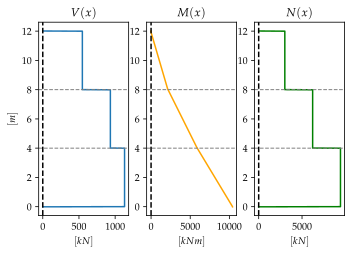

In [19]:
#| label: fig-ekv_rayleigh_schnittgroessen
#| fig-cap: "Maximale Schnittgrössen"


params_plot = convert.param_value(params)
# Querkraft

F_y_i = list(F_y_i_dict.values())[::-1]
V_max = [F_y_i[0], F_y_i[0]+F_y_i[1],F_y_i[0]+F_y_i[1]+F_y_i[2]][::-1]
V_x = sp.Piecewise((V_max[0].subs(params)/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))), (V_max[1].subs(params)/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))), (V_max[2].subs(params)/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))


# Biegemoment
M_x = sp.integrate(-V_x, x) + C_1
C_1_solve = sp.solve(M_x.subs(x, (H_1+H_2+H_3).subs(params_plot)), C_1)[0]
M_x = M_x.subs(C_1, C_1_solve)

# Normalkraft
g = 10*unit.m/unit.second**2
N_x = sp.Piecewise(((m_1+m_2+m_3).subs(params)*g/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))),((m_3+m_2).subs(params)*g/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))),((m_3).subs(params)*g/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))



# Numerische Daten generieren
x_array = np.linspace(-0.01, float((H_1+H_2+H_3+.01).subs(params_plot)), 1000)
V_x_lamb = sp.lambdify(x, V_x)
V_x_array = V_x_lamb(x_array)

M_x_lamb = sp.lambdify(x,M_x)
M_x_array = M_x_lamb(x_array)

N_x_lamb = sp.lambdify(x,N_x)
N_x_array = N_x_lamb(x_array)

# Figure und Axes erstellen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Ersten Plot erstellen

ax1.plot(V_x_array/1000, x_array)
ax1.set_title('$V(x)$')

## Horizontale Linien
ax1.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax1.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax1.set_xlabel('$[kN]$')
ax1.set_ylabel('$[m]$')

ax1.axvline(0,linestyle='dashed', color='black')


# Zweiten Plot erstellen

ax2.plot(M_x_array/1000, x_array, color='orange')
ax2.set_title('$M(x)$')

## Horizontale Linien
ax2.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax2.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax2.set_xlabel('$[kNm]$')

ax2.axvline(0,linestyle='dashed', color='black')


# Dritten Plot erstellen

ax3.plot(N_x_array/1000, x_array, color='green')
ax3.set_title('$N(x)$')
ax3.set_xlabel('$[kN]$')


## Horizontale Linien
ax3.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax3.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)


ax3.axvline(0,linestyle='dashed', color='black')



# Plots anzeigen
plt.show()

Unter der Annahme das der Einspanngrad der Tragwand in die *biegeweiche* Bodenplatte zu vernachlässigen ist,
kann das Biegemoment am Kragarm in ein Kräftepaar mit der Stockwerkshöhe im UG von 4m aufgelöst werden. Entsprechend dem System in @fig-ekv_rayleigh_systemansicht.
Somit ergeben sich nachfolgend dargestellten Schnittkräfte.
Elastische Einspanngrade in die Bodenplatte können in Abhängigkeit der Steifigkeit der Fundation
berücksichtigt werden.
Zu beachten sind die hohen Querkräfte der Tragwand im UG. Da infolge Querkraft ein sprödes Versagen erfolgt,
ist bei der Querkraft-Bemessung besonders Beachtung zu schenken.


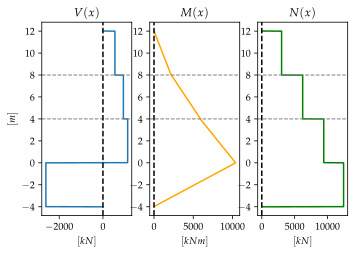

In [20]:
#| label: fig-ekv_rayleigh_schnittgroessen_UG
#| fig-cap: "Maximale Schnittgrössen erweitert in das UG"


params_plot = convert.param_value(params)
# Querkraft

F_y_i = list(F_y_i_dict.values())[::-1]
V_max = [F_y_i[0], F_y_i[0]+F_y_i[1],F_y_i[0]+F_y_i[1]+F_y_i[2]][::-1]
V_x = sp.Piecewise((-np.sum(V_max).subs(params)/unit.N, ((x<0)&(x>=-H_1.subs(params_plot)))),(V_max[0].subs(params)/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))), (V_max[1].subs(params)/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))), (V_max[2].subs(params)/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))


# Biegemoment
M_x = sp.integrate(-V_x, x) + C_1
C_1_solve = sp.solve(M_x.subs(x, (H_1+H_2+H_3).subs(params_plot)), C_1)[0]
M_x = M_x.subs(C_1, C_1_solve)

# Normalkraft
g = 10*unit.m/unit.second**2
N_x = sp.Piecewise(((m_1+m_2+m_3*2).subs(params)*g/unit.N, ((x<0)&(x>=-H_1.subs(params_plot)))),((m_1+m_2+m_3).subs(params)*g/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))),((m_3+m_2).subs(params)*g/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))),((m_3).subs(params)*g/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))



# Numerische Daten generieren
x_array = np.linspace(float((-H_1-.01).subs(params_plot)), float((H_1+H_2+H_3+.01).subs(params_plot)), 1000)
V_x_lamb = sp.lambdify(x, V_x)
V_x_array = V_x_lamb(x_array)

M_x_lamb = sp.lambdify(x,M_x)
M_x_array = M_x_lamb(x_array)

N_x_lamb = sp.lambdify(x,N_x)
N_x_array = N_x_lamb(x_array)

# Figure und Axes erstellen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Ersten Plot erstellen

ax1.plot(V_x_array/1000, x_array)
ax1.set_title('$V(x)$')

## Horizontale Linien
ax1.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax1.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax1.set_xlabel('$[kN]$')
ax1.set_ylabel('$[m]$')

ax1.axvline(0,linestyle='dashed', color='black')


# Zweiten Plot erstellen

ax2.plot(M_x_array/1000, x_array, color='orange')
ax2.set_title('$M(x)$')

## Horizontale Linien
ax2.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax2.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax2.set_xlabel('$[kNm]$')

ax2.axvline(0,linestyle='dashed', color='black')


# Dritten Plot erstellen

ax3.plot(N_x_array/1000, x_array, color='green')
ax3.set_title('$N(x)$')
ax3.set_xlabel('$[kN]$')


## Horizontale Linien
ax3.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax3.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)


ax3.axvline(0,linestyle='dashed', color='black')



# Plots anzeigen
plt.show()

In einem weiteren Schritt sind die Auflagerkräfte in der Decke über UG und in der Bodenplatte mit einem
geeigneten Fachwerkmodell in die Aussenwände (ebene Scheibe) abzuleiten.
Des weiteren ist auf die lokale Lasteinleitung der Auflagerkräfte in die Decken bzw. Bodenplatte
zu achten bzw. rechnerisch nachzuweisen.

In [21]:
R_A = -V_x.subs(x,-3)*unit.N
R_B = (V_x.subs(x,-3) - V_x.subs(x,1)) * unit.N

render.eq_display('R_A', R_A,
                  'R_B', R_B)

R_A = 2.61e+6⋅newton

R_B = -3.74e+6⋅newton

### Formfunktion analytisch

Als Formfunktion wählen wir die bekannte normierte analytische Funktion für den Kragstab, welche die kinematischen Randbedingungen erfüllt.

#### Rayleigh-Quotient

In [22]:
params[H] = (H_1 + H_2 + H_3).subs(params)

In [23]:
Psi_x = 1 - sp.cos(sp.pi * x / ( 2*H))
render.eq_display('H', H.subs(params),
                  'Psi(x)', Psi_x)

H = 12⋅meter

              ⎛π⋅x⎞
Ψ(x) = 1 - cos⎜───⎟
              ⎝2⋅H⎠

$$
E_{pot,max} = E_{kin,max}
$${#eq-ekv_rayleigh_balken_energie}

$$
\omega_1^2 = \frac{\int_0^L EI[u''(x)]^2 dx}{\int_0^L m_{const.}[u(x)]^2 dx}
$${#eq-ekv_rayleigh_balken_quotient}

Dies lässt sich mit entsprechender Formfunktion schreiben:

$$
\omega_1^2 = \frac{\int_0^L EI[\Psi''(x)]^2 dx}{\int_0^L m_{const.}[\Psi(x)]^2 dx}
$${#eq-ekv_rayleigh_balken_quotient_subs}

Durch die Ermittlung der zweiten Ableitung der Formfunktion:

In [24]:
Psi_x_diff_1 = sp.diff(Psi_x, x)
Psi_x_diff_2 = sp.diff(Psi_x, x,x)


render.eq_display('Psi(x)', Psi_x,
                  'Derivative(Psi(x),x)', Psi_x_diff_1,
                  'Derivative(Psi(x),x,x)', Psi_x_diff_2,)

              ⎛π⋅x⎞
Ψ(x) = 1 - cos⎜───⎟
              ⎝2⋅H⎠

                ⎛π⋅x⎞
           π⋅sin⎜───⎟
d               ⎝2⋅H⎠
──(Ψ(x)) = ──────────
dx            2⋅H    

             2    ⎛π⋅x⎞
  2         π ⋅cos⎜───⎟
 d                ⎝2⋅H⎠
───(Ψ(x)) = ───────────
  2                2   
dx              4⋅H    

Die Funktionswerte der Punktmassen:

In [25]:
Psi_x1 = Psi_x.subs(x, sp.Rational(1,3)*H)
Psi_x2 = Psi_x.subs(x, sp.Rational(2,3)*H)
Psi_x3 = Psi_x.subs(x, sp.Rational(3,3)*H)

render.eq_display('Psi_x1(1/3*H)', Psi_x1.evalf(3),
                 'Psi_x2(2/3*H)', Psi_x2,
                 'Psi_x3(H)', Psi_x3
                 )

   ⎛H⎞        
Ψₓ₁⎜─⎟ = 0.134
   ⎝3⎠        

   ⎛2⋅H⎞      
Ψₓ₂⎜───⎟ = 1/2
   ⎝ 3 ⎠      

Ψₓ₃(H) = 1

#### Eigenkreisfrequenz

@eq-ekv_rayleigh_balken_quotient_subs umgeformt und substituiert:

$$
\omega_1 = \sqrt{\frac{k^\star}{m^\star}}
$${#eq-rayleigh_2pm_grundfreq}

Masse:

In [26]:
m_star = m_1*Psi_x1**2 + m_2 *Psi_x2**2 + m_3 * Psi_x3**2
m_star

render.eq_display(sp.Symbol('m^\star'), "m_1*Psi_x1**2 + m_2 *Psi_x2**2 + m_3 * Psi_x2**2",
                  sp.Symbol('m^\star'), m_star,
                  sp.Symbol('m^\star'), m_star.subs(params).evalf(3),
                 )

              2         2         2   
m__\star = Ψₓ₁ ⋅m₁ + Ψₓ₂ ⋅m₂ + Ψₓ₂ ⋅m₃

                      2          
              ⎛    √3⎞    m₂     
m__\star = m₁⋅⎜1 - ──⎟  + ── + m₃
              ⎝    2 ⎠    4      

                                2
           3.88e+5⋅newton⋅second 
m__\star = ──────────────────────
                   meter         

Steifigkeit:

In [27]:
k_star = EI_y_ersatz*sp.integrate(Psi_x_diff_2**2, (x, 0, H))


render.eq_display(sp.Symbol('k^\star'), "EI_y_ersatz*Integral(Derivative(Psi(x),x,x)**2, (x, 0, L))",
                  sp.Symbol('k^\star'), k_star,
                  sp.Symbol('k^\star'), k_star.subs(params).evalf(3).simplify(),
                 )

                       L                
                       ⌠                
                       ⎮            2   
                       ⎮ ⎛  2      ⎞    
                       ⎮ ⎜ d       ⎟    
k__\star = EI_y_ersatz⋅⎮ ⎜───(Ψ(x))⎟  dx
                       ⎮ ⎜  2      ⎟    
                       ⎮ ⎝dx       ⎠    
                       ⌡                
                       0                

            4       3       
           π ⋅E⋅L_w3 ⋅d⋅γ_EI
k__\star = ─────────────────
                      3     
                 384⋅H      

           8.25e+7⋅newton
k__\star = ──────────────
               meter     

Eigenkreisfrequenz:

In [28]:
omega_1 = sp.sqrt(k_star /m_star)
render.eq_display('omega_1', omega_1.subs(params).simplify().evalf(3))

      14.6 
ω₁ = ──────
     second

Eigenfrequenz und Eigenperiode:

In [29]:
f_1 = omega_1 / 2 / sp.pi
T_1 = 1 / f_1

render.eq_display('f_1', f_1.subs(params).simplify().evalf(3),
                  'T_1', T_1.subs(params).simplify().evalf(3))

      2.32 
f₁ = ──────
     second

T₁ = 0.43⋅second

### Erweiterung des Rayleigh-Quotienten

Eine Erweiterung des Rayleigh-Quotienten besteht in der näherungsweise Berücksichtigung von Schubverformungen und Fundamentverdrehungen. Beide führen zu einem weicheren System. Bei langen Stahlbetonwänden und Mauerwekrswänden sind die Schubverformungen zu berücksichtigen. Bei weichem Baugrund folglich die Fundamentverdrehungen.


Die @fig-ekv_rayleigh_feder zeigt ein idealisiertes Kragsystem für einen Mehrmassenschwinger in ausgelenkter Lage. Es gilt die Annahme für kleine Winkel $\tan(\phi) = \phi$.

![Mehrmassenschwinger erweitert mit einer Fundamentverdrehung und Schubsteifigkeit](bilder/aufgabe_ekv_rayleigh_biege_feder.svg){#fig-ekv_rayleigh_feder}

Die Eigenform wird mit einer linearen Formfunktion $\Psi(x)$ angenähert.

In [30]:

Psi_x = (u_0 / H * x)
Psi_x_diff_2 = sp.Derivative(Psi_x, x,x).doit()

render.eq_display('Psi(x)', Psi_x,
                  'Derivative(Psi(x),x,x)', Psi_x_diff_2,
                 'Psi(0)', Psi_x.subs(x,0),
                 'Psi(H)', Psi_x.subs(x,H))

       u₀⋅x
Ψ(x) = ────
        H  

  2          
 d           
───(Ψ(x)) = 0
  2          
dx           

Ψ(0) = 0

Ψ(H) = u₀

#### Rayleigh-Quotient

Der Rayleigh-Quotient lässt sich in Analogie des Vorgehens in @eq-ekv_rayleigh_arbeit folgendermassen beschreiben:

$$
\omega_1^2 = \frac{F\cdot u_0}{\sum_{i=1}^n m_i [\Psi_i(x)]^2}
$${#eq-ekv_rayleigh_eigenkreisfreq_drehfeder}

Die Verformung $u_0$ setzt aus einer Reihenschaltung von Federn zusammen und bezeichnet die Nachgiebigkeit. Diese Nachgiebigkeiten setzen sich aus der Beige- und Schubverformung des Stabes und der Fundamntdrehung infolge dem Einspannmoment $M = 1 \cdot H$ zusammen.


$$
u_0 = \frac{H^3}{3 \cdot EI} + \frac{H}{G\cdot A_s} + \frac{H^2}{k_\phi}
$${#eq-ekv_rayleigh_u0}


##### Schubverformung


Die @eq-ekv_rayleigh_u0 wird folgend hergeleitet:

$$
\gamma = \frac{\tau}{G} = \frac{\frac{V}{A_s}}{G} =  \frac{u_G}{H}
$${#eq-ekv_rayleigh_schubwinkel}

$\gamma = \text{Schubwinkel}$ Der Schubwinkel ist bei der Schubspannung *gleichbedeutent* wie die Dehnung $\varepsilon$ bei der Normalspannung.

$\tau = \frac{V}{A_s}$ Die Schubspannung definiert sich aus der Querkraft über die Querschnittsfläche. Als Annahme gilt eine konstante Schubspannungsverteilung über die Wandlänge.

$G = \text{Schubmodul}$ Der Schubmodul ist der Elasitzitätsmodul bei den Schubspannungen.

$u_G = \text{Anteil an Gesamtverformung}$ 

Gleichung @eq-ekv_rayleigh_schubwinkel lässt sich nach $u_G$ umformen für $V = 1$:

$$
u_G = \frac{H}{G\cdot A_s}
$${#eq-ekv_rayleigh_u_G}


Zur Beziehung, es lässt sich ein Dreieck aus $u_G$ und $H$ bilden, der Winkel am Fusspunkt entspricht dem Schubwinkel.

$$
\gamma = \frac{u_G}{H}
$${#eq-ekv_rayleigh_gamma}

##### Fundamentverdrehung

Infolge elastischer Lagerung resultiert die Fundamentverdrehung:

$$
k_{\varphi} = \frac{M}{\varphi}
$${#eq-ekv_rayleigh_drehfeder}

Das Biegemoment resultiert aus $F=1$ mit entsprechendem Hebelarm. Die Verdrehung folgt aus der Kopfverschiebung verteilt an die Systemhöhe. Gleiche Winkelbetrachtung wie bei dem Schubwinkel.
Mit $M = 1 \cdot H$ und $\varphi = \frac{u_{\varphi}}{H}$


$$
u_{\varphi} = \frac{H^2}{k_{\varphi}}
$${#eq-ekv_rayleigh_anteil_u_phi}

$u_{\varphi} = \text{Anteil an Gesamtverformung}$


##### Biegeverformung

Für die Biegeverformung gilt folgendes:
$$
u_B = \frac{F}{k}
$${#eq-ekv_rayleigh_u_B}

Die Steifigkeit für den eingespannten Kragarm:
$$
k = \frac{3 \cdot EI }{H^3}
$${#eq-ekv_rayleigh_k}

#### Nachgiebigkeiten

Wir wissen nun, welchen Einfluss die Fundamentverdrehung, sowie die Schubverformung auf den Rayleigh-Quotienten hat. Nun gilt es die Federsteifigkeit zu definieren.




##### Schubverformung

Dabei gilt, die Schubsteifigkeit wird um den gleichen Faktor wie die Biegesteifigkeit abgemindert, um das Rissverhalten zu berücksichtigen.

In [31]:
A_s = (L_w3 * d)
nu_c = 0.2
G_c = (E / (2*(1-nu_c)))

render.eq_display('A_s', A_s,
                  'A_s', A_s.subs(params),
                  'nu_c', nu_c,
                  'G_c', '(E_ / (2*(1-nu_c)))',
                  'G_c', G_c.subs(params))

Aₛ = L_w3⋅d

              2
Aₛ = 1.5⋅meter 

ν_c = 0.2

          E    
G_c = ─────────
      2 - 2⋅ν_c

      18750.0⋅newton
G_c = ──────────────
                 2  
       millimeter   

Schubsteifigkeit der Tragwand:

In [32]:
G_cA_2 = G_c*gamma_EI * A_s
render.eq_display(
    'GA_II', 'G_c*gamma_EI * A_s',
    'GA_II', G_cA_2.subs(params).simplify())

GA_II = Aₛ⋅G_c⋅γ_EI

GA_II = 14062500000.0⋅newton

Verformungsanteil durch die Querkraft:

In [33]:
u_g = H / G_cA_2

render.eq_display('u_g', u_g.subs(params).simplify().evalf(3))

      8.53e-10⋅meter
u_g = ──────────────
          newton    

##### Fundamentverdrehung

Sowie wird die Fundamentsteifigkeit nach @SIA269/8 Tabelle 7 ermittelt. Der Baugrund wird als locker gelagerter Sand angenommen. Effektive Werte sind aus geologischen Berichten zu entnehmen. Dabei ist die Baugrundklasse zu berücksichtigen:

Bodenkennwert nach Tabelle 6:

In [34]:
G_eff = G_eff_sand * 0.935

render.eq_display('G_eff','G_eff_sand * 0.935',
                  'G_eff', G_eff.subs(params))

G_eff = 0.935⋅G_eff_sand

        112200000.0⋅newton
G_eff = ──────────────────
                   2      
              meter       

Drehfeder Baugrund nach Tabelle 7 und Tabelle 8

In [35]:
a = 5 * L_x
b = 3 * L_y

k_xx = (G_eff * b**3 / (1-nu_sand)) * (0.4 * (a/b)+0.1)


render.eq_display(

    'b', b.subs(params),
    'a', a.subs(params),
    'k_xx', 'G_eff * b**3 / (1-nu_sand) * (0.4 * (a/b)+0.1)',
    'k_xx', k_xx.subs(params).simplify().evalf(3))

b = 15⋅meter

a = 20⋅meter

             3 ⎛0.4⋅a      ⎞
      G_eff⋅b ⋅⎜───── + 0.1⎟
               ⎝  b        ⎠
kₓₓ = ──────────────────────
            1 - ν_sand      

kₓₓ = 3.43e+11⋅meter⋅newton

Multiplikationsfaktor zur Berücksichtigung der Einspannung:

In [36]:

h_2 = 4*unit.m + d/2
h_3 = d
h_1 = h_2 - (h_3/2)

m_xx = 1 + sp.Rational(2.5)*h_3 / b * (1 + 2*h_3 / b *(h_3/h_2)**(-0.2) * sp.sqrt(b/a))

render.eq_display(
    'h_1', h_1.subs(params),
    'h_2', h_2.subs(params),
    'h_3', h_3.subs(params),
    'm_xx','1 + 2.5*h_3 / b * (1 + 2*h_3 / b *(h_3/h_2)**(-0.2) * sqrt(b/a))',
    
    'm_xx', m_xx.subs(params).evalf(4))

h₁ = 4⋅meter

h₂ = 4.15⋅meter

h₃ = 0.3⋅meter

                 ⎛             ___     -0.2⎞
                 ⎜            ╱ b  ⎛h₃⎞    ⎟
                 ⎜    2⋅h₃⋅  ╱  ─ ⋅⎜──⎟    ⎟
                 ⎜         ╲╱   a  ⎝h₂⎠    ⎟
          2.5⋅h₃⋅⎜1 + ─────────────────────⎟
                 ⎝              b          ⎠
mₓₓ = 1 + ──────────────────────────────────
                          b                 

mₓₓ = 1.053

Drehfeder unter Berücksichtigung der Einspannung:

In [37]:
k_xx = k_xx * m_xx

render.eq_display('k_xx', k_xx.subs(params).evalf(3))

kₓₓ = 3.61e+11⋅meter⋅newton

In @eq-ekv_rayleigh_anteil_u_phi eingesetzt:

In [38]:
u_phi = H**2 / k_xx

render.eq_display('u_varphi', u_phi.subs(params).evalf(3))

          3.99e-10⋅meter
uᵥₐᵣₚₕᵢ = ──────────────
              newton    

##### Biegeverformung

In [39]:
k_biege = 3*EI_y_ersatz / H**3
u_B = 1/k_biege

render.eq_display('k_biege', k_biege.subs(params).evalf(3),
                  'u_B', u_B.subs(params).evalf(3).simplify())


          81.4⋅meter⋅newton
k_biege = ─────────────────
                       2   
             millimeter    

      1.23e-8⋅meter
u_B = ─────────────
          newton   

##### Totale Deformation

In [40]:
params[F] = 1
params[u_0] = (u_B + u_g + u_phi).subs(params).simplify()

render.eq_display(
    
    'u_0', 'u_B + u_g + u_phi',
    'u_0', u_0.subs(params).evalf(3).simplify())

u₀ = u_B + u_g + uᵩ

     1.35e-8⋅meter
u₀ = ─────────────
         newton   

Eingesetzt in @eq-ekv_rayleigh_eigenkreisfreq_drehfeder:

In [41]:
omega_1_squared = F*u_0 / (m_1 * Psi_x.subs(x, H_1)**2 + m_2 * Psi_x.subs(x, H_2+H_1)**2 +m_3 * Psi_x.subs(x, H_3+H_2+H_1)**2)

omega_1 = sp.sqrt(omega_1_squared)

render.eq_display(
    'omega_1^2', omega_1_squared.subs(params).evalf(3).simplify(),
    'omega_1', omega_1.subs(params).evalf(3).simplify()
)

  2    154.0 
ω₁  = ───────
            2
      second 

      12.4 
ω₁ = ──────
     second

In [42]:

f_1 = omega_1 / 2 / sp.pi
T_1 = 1 / f_1


render.eq_display(
    'f_1', f_1.subs(params).simplify().evalf(3),
    'T_1', T_1.subs(params).simplify().evalf(3)
)

      1.97 
f₁ = ──────
     second

T₁ = 0.506⋅second

#### Bemessungsspektrum

In [43]:
a_gd = 1.0*unit.m /unit.second**2


In [44]:
S_d_y = bemessungsspektrum(a_gd, T_1.subs(params).simplify().evalf(3), params['q'], params['gamma_f'], Baugrundklasse='B')

render.eq_display('S_d_y', S_d_y.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $a_{gd} = \frac{1.0 \text{m}}{\text{s}^{2}}$ | $g = \frac{10.0 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{f} = 1.0$ | $q = 2.0$ |


      2.5⋅S⋅T_C⋅a_gd⋅γ_f
S_d = ──────────────────
            T⋅g⋅q       

S_d_y = 0.104

#### Gesamt-Ersatzkraft

Das Vorgehen ist analog @eq-ekv_rayleigh_v_stock und folgenden. 


In [45]:
F_d_y_nach = np.sum(np.array([m_1, m_2, m_3])*g*S_d_y)
Red = (1-(F_d_y / F_d_y_nach).subs(params).evalf(3))*100*unit.percent

render.eq_display('F_d_y_nach', F_d_y_nach.subs(params).evalf(3),
                 'Reduktion', Red)

F_d_y_nach = 9.78e+5⋅newton

Reduktion = -15.4⋅percent

Im Vergleich mit der Lösung ohne Nachgiebigkeit verringert sich die Gesamt-Ersatzkraft um ca. 15 % und folglich die Schnittgrössen ebenfalls. Wenn die Eigenperiode im abfallenden Ast des Spektrums zu liegen kommt, ist die Berücksichtigung
der Nachgiebigkeiten eine wirtschaftliche Lösung.

In [46]:
H_masse_i = np.array([(H_1) * m_1,(H_1+H_2) * m_2,(H_1+H_2+H_3) * m_3])

F_y_i = H_masse_i / np.sum(H_masse_i) * F_d_y_nach


F_y_i_dict = {f'F_y{i+1}': F_y_i[i].subs(params).evalf(3) for i in range(len(F_y_i))}
render.dict_to_table(F_y_i_dict)

|   |   |
|---|---|
| $F_{y1} = 1.68 \cdot 10^{5} \text{N}$ | $F_{y2} = 3.36 \cdot 10^{5} \text{N}$ |
| $F_{y3} = 4.74 \cdot 10^{5} \text{N}$ | |


#### Schnittgrössen

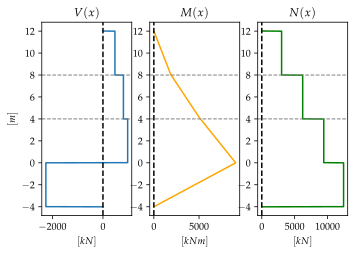

In [47]:
#| label: fig-ekv_rayleigh_schnittgroessen_UG_dreh
#| fig-cap: "Maximale Schnittgrössen erweitert in das UG unter Berücksichtung der Nachgiebigkeiten"


params_plot = convert.param_value(params)
# Querkraft

F_y_i = list(F_y_i_dict.values())[::-1]
V_max = [F_y_i[0], F_y_i[0]+F_y_i[1],F_y_i[0]+F_y_i[1]+F_y_i[2]][::-1]
V_x = sp.Piecewise((-np.sum(V_max).subs(params)/unit.N, ((x<0)&(x>=-H_1.subs(params_plot)))),(V_max[0].subs(params)/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))), (V_max[1].subs(params)/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))), (V_max[2].subs(params)/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))


# Biegemoment
M_x = sp.integrate(-V_x, x) + C_1
C_1_solve = sp.solve(M_x.subs(x, (H_1+H_2+H_3).subs(params_plot)), C_1)[0]
M_x = M_x.subs(C_1, C_1_solve)

# Normalkraft
g = 10*unit.m/unit.second**2
N_x = sp.Piecewise(((m_1+m_2+m_3*2).subs(params)*g/unit.N, ((x<0)&(x>=-H_1.subs(params_plot)))),((m_1+m_2+m_3).subs(params)*g/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))),((m_3+m_2).subs(params)*g/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))),((m_3).subs(params)*g/unit.N, ((x>=(H_1+H_2).subs(params_plot))&(x<=(H_1+H_2+H_3).subs(params_plot)))), (0,True))



# Numerische Daten generieren
x_array = np.linspace(float((-H_1-.01).subs(params_plot)), float((H_1+H_2+H_3+.01).subs(params_plot)), 1000)
V_x_lamb = sp.lambdify(x, V_x)
V_x_array = V_x_lamb(x_array)

M_x_lamb = sp.lambdify(x,M_x)
M_x_array = M_x_lamb(x_array)

N_x_lamb = sp.lambdify(x,N_x)
N_x_array = N_x_lamb(x_array)

# Figure und Axes erstellen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Ersten Plot erstellen

ax1.plot(V_x_array/1000, x_array)
ax1.set_title('$V(x)$')

## Horizontale Linien
ax1.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax1.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax1.set_xlabel('$[kN]$')
ax1.set_ylabel('$[m]$')

ax1.axvline(0,linestyle='dashed', color='black')


# Zweiten Plot erstellen

ax2.plot(M_x_array/1000, x_array, color='orange')
ax2.set_title('$M(x)$')

## Horizontale Linien
ax2.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax2.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax2.set_xlabel('$[kNm]$')

ax2.axvline(0,linestyle='dashed', color='black')


# Dritten Plot erstellen

ax3.plot(N_x_array/1000, x_array, color='green')
ax3.set_title('$N(x)$')
ax3.set_xlabel('$[kN]$')


## Horizontale Linien
ax3.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax3.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)


ax3.axvline(0,linestyle='dashed', color='black')



# Plots anzeigen
plt.show()

In [48]:
R_A_nach = -V_x.subs(x,-3)*unit.N
R_B_nach = (V_x.subs(x,-3) - V_x.subs(x,1)) * unit.N

render.eq_display('R_A', R_A_nach,
                  'R_B', R_B_nach)

R_A = 2.26e+6⋅newton

R_B = -3.24e+6⋅newton

### Reduktion der Wandlänge

Neben der Berücksichtigung der Nachgiebigkeit seitens Fundation und Schubverformungen, hat die Wandlänge einen wesentlichen Einfluss auf Ersatzkräfte. Die @tbl-ekv_rayleigh_wandlaengen zeigt den Einfluss der Wandlänge $L_{w3}$ auf die Erdbebenersatzkräfte. Als obere Grenze gilt die Bedingung aus @SIA261_2020 Ziff. 16.5.2.1, die Grundschwingzeit darf $4\cdot T_c$ nicht überschreiten.

|          | $5$ m       | $4$ m       | $3$ m       |
|:---------|:------------|:------------|:------------|
| $F_d$    | $1128.4$ kN | $803.50$ kN | $519.28$ kN |
| $F_{3d}$ | $546.50$ kN | $390.06$ kN | $252.66$ kN |
| $F_{2d}$ | $387.88$ kN | $275.63$ kN | $177.75$ kN |
| $F_{1d}$ | $193.94$ kN | $137.81$ kN | $88.875$ kN |
| $T_1$    | $0.439$ s   | $0.612$ s   | $0.939$ s   |

: Einfluss der Wandlänge auf die Ersatzkräfte und Grundschwingzeit {#tbl-ekv_rayleigh_wandlaengen}


In [49]:
T_C = 0.35*unit.second

T_1_max = 4 * T_C

render.eq_display(
    'T_1_max', '4*T_C',
    'T_1_max', T_1_max)

T₁ ₘₐₓ = 4⋅T_C

T₁ ₘₐₓ = 1.4⋅second